# Analyse Robert Lewandowski's Stats

In [ ]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
players_df = pd.read_csv("players_stats_fcbarcelona_matchs_2022_2023.csv")


In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
players_df.columns

Index(['Unnamed: 0', 'id', 'usingOptaId', 'name', 'imageUrl', 'pageUrl',
       'shirt', 'isHomeTeam', 'timeSubbedOn', 'timeSubbedOff', 'usualPosition',
       'positionRow', 'role', 'events', 'teamName', 'home_team', 'away_team',
       'score', 'shortName', 'isCaptain', 'rating', 'fantasyScore',
       'minutesPlayed', 'shotmap', 'stats', 'teamData', 'positionStringShort'],
      dtype='object')

# Data cleaning and preparation 


In [ ]:
players_df["name"] = players_df["name"].apply(lambda x:eval(x))

In [ ]:

players_df['first_name'] = players_df['name'].apply(lambda x: x['firstName'])
players_df['last_name'] = players_df['name'].apply(lambda x: x['lastName'])

In [ ]:
players_df.iloc[470].stats

"[{'title': 'Top stats', 'stats': {'FotMob rating': 6.19, 'Minutes played': 27, 'Goals': 0, 'Assists': 0, 'Total shots': 2, 'Shotmap': True, 'Accurate passes': '14/16 (88%)', 'Chances created': 1, 'Expected goals (xG)': '0.35', 'Expected assists (xA)': '0.31'}}, {'title': 'Attack', 'stats': {'Shot accuracy': '1/2 (50%)', 'Big chance missed': 1, 'Touches': 25, 'Passes into final third': 1, 'Accurate long balls': '2/2 (100%)', 'Dispossessed': 2}}, {'title': 'Defence', 'stats': {'Tackles won': '0/1 (0%)', 'Interceptions': 1}}, {'title': 'Duels', 'stats': {'Ground duels won': '2/5 (40%)', 'Aerial duels won': 0, 'Was fouled': 1, 'Fouls committed': 1}}]"

# feature engineering

In [ ]:
lewandowski = players_df.query("first_name == 'Robert' & last_name == 'Lewandowski'")

In [ ]:
lewa_stats = lewandowski[~lewandowski["stats"].isna()]

In [ ]:
# extract opponent team
lewa_team_info = pd.DataFrame(lewa_stats["isHomeTeam"])
# extract opponent team
lewa_team_info["opponent_team"] = np.where(lewa_stats['home_team'] == "Barcelona", lewa_stats['away_team'], lewa_stats['home_team'])
# extract barca and opponent score
lewa_team_info["barca_score"] = np.where(lewa_stats['home_team'] == "Barcelona",
                                         lewa_stats['score'].str.split(" - ").apply(lambda x: x[0]),
                                         lewa_stats['score'].str.split(" - ").apply(lambda x: x[1]))
lewa_team_info["opponent_score"] = np.where(lewa_stats['away_team'] == "Barcelona",
                                         lewa_stats['score'].str.split(" - ").apply(lambda x: x[0]),
                                         lewa_stats['score'].str.split(" - ").apply(lambda x: x[1]))

def result(row):
    if row["barca_score"] > row ["opponent_score"]:
        return "Win"
    elif row["barca_score"] < row ["opponent_score"]:
        return "Lose"
    else:
        return "Draw"
#match result
lewa_team_info["result"] = lewa_team_info.apply(result, axis=1)

In [ ]:
lewa_team_info.head()

,isHomeTeam,opponent_team,barca_score,opponent_score,result
280,True,Rayo Vallecano,0,0,Draw
340,False,Real Sociedad,4,1,Win
422,True,Real Valladolid,4,0,Win
481,False,Sevilla,3,0,Win
512,True,Viktoria Plzen,5,1,Win


In [ ]:
lewa_game_stats = lewa_stats.stats
all_stats_df = pd.DataFrame()
index = 1
for row in lewa_game_stats:
  df = pd.DataFrame()
  for stats in eval(row):
      dict_stats = stats['stats']
      stats_df = pd.DataFrame.from_dict(dict_stats, orient='index', columns=[index]).T
      df = pd.concat([df, stats_df], axis=1)
  index += 1
  all_stats_df = all_stats_df.append(df)

<ipython-input-21-235684567681>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_stats_df = all_stats_df.append(df)
<ipython-input-21-235684567681>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_stats_df = all_stats_df.append(df)
<ipython-input-21-235684567681>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_stats_df = all_stats_df.append(df)
<ipython-input-21-235684567681>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_stats_df = all_stats_df.append(df)
<ipython-input-21-235684567681>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

In [ ]:
all_stats_df.head()

,FotMob rating,Minutes played,Goals,Assists,Total shots,Shotmap,Accurate passes,Chances created,Expected goals (xG),Expected goals on target (xGOT),Expected assists (xA),Shot accuracy,Big chance missed,Blocked shots,Touches,Successful dribbles,Passes into final third,Accurate crosses,Accurate long balls,Offsides,Dispossessed,Tackles won,Clearances,Headed clearance,Recoveries,Dribbled past,Ground duels won,Aerial duels won,Was fouled,Fouls committed,Interceptions,Penalties miss,Blocks
1,6.78,90,0,0,5,True,11/16 (69%),2,0.86,0.89,0.05,1/4 (25%),1,1,44,0/1 (0%),2,1/1 (100%),1/2 (50%),1,2,2/2 (100%),1,1,1,1,6/12 (50%),0/1 (0%),4,2,NaN,NaN,NaN
2,8.87,90,2,0,4,True,27/30 (90%),2,0.89,1.84,0.14,4/4 (100%),NaN,NaN,46,0/1 (0%),2,NaN,1/1 (100%),1,3,0/1 (0%),NaN,NaN,3,NaN,3/8 (38%),2/3 (67%),2,1,NaN,NaN,NaN
3,9.24,90,2,0,5,True,27/31 (87%),3,0.88,2.03,0.18,3/4 (75%),2,1,48,3/5 (60%),2,NaN,1/1 (100%),NaN,2,0,NaN,NaN,1,2,4/11 (36%),2/5 (40%),1,1,NaN,NaN,NaN
4,8.05,74,1,0,4,True,14/17 (82%),1,1.27,2.17,0.01,4/4 (100%),3,NaN,31,1/4 (25%),2,NaN,NaN,NaN,1,0,NaN,NaN,NaN,NaN,3/7 (43%),0,2,0,NaN,NaN,NaN
5,9.71,90,3,0,6,True,24/35 (69%),2,1.10,1.90,0.86,4/4 (100%),NaN,2,51,1/2 (50%),NaN,0/1 (0%),NaN,NaN,1,1/1 (100%),NaN,NaN,1,NaN,3/6 (50%),1/1 (100%),1,1,NaN,NaN,NaN


In [ ]:
passes_df = all_stats_df['Accurate passes'].str.extract(r'(?P<passes_number>\d+)/(?P<accurate_passes_number>\d+)\s*\((?P<pass_accuracy>\d+)%\)').astype(int)
passes_df["pass_accuracy"] /= 100

In [ ]:
passes_df.head()

,passes_number,accurate_passes_number,pass_accuracy
1,11,16,0.69
2,27,30,0.90
3,27,31,0.87
4,14,17,0.82
5,24,35,0.69


In [ ]:
useful_stats = all_stats_df[["FotMob rating","Minutes played","Goals"	,"Assists"	,"Total shots", "Chances created", "Expected goals (xG)", "Expected goals on target (xGOT)","Expected assists (xA)", "Touches"]].astype(float)

In [ ]:

useful_stats = pd.concat([useful_stats, passes_df], axis=1)

In [ ]:
useful_stats.head()

,FotMob rating,Minutes played,Goals,Assists,Total shots,Chances created,Expected goals (xG),Expected goals on target (xGOT),Expected assists (xA),Touches,passes_number,accurate_passes_number,pass_accuracy
1,6.78,90.0,0.0,0.0,5.0,2.0,0.86,0.89,0.05,44.0,11,16,0.69
2,8.87,90.0,2.0,0.0,4.0,2.0,0.89,1.84,0.14,46.0,27,30,0.90
3,9.24,90.0,2.0,0.0,5.0,3.0,0.88,2.03,0.18,48.0,27,31,0.87
4,8.05,74.0,1.0,0.0,4.0,1.0,1.27,2.17,0.01,31.0,14,17,0.82
5,9.71,90.0,3.0,0.0,6.0,2.0,1.10,1.90,0.86,51.0,24,35,0.69


In [ ]:
xg_shots = useful_stats.groupby("Total shots")["Expected goals (xG)"].mean()
xgot_shots = useful_stats.groupby("Total shots")["Expected goals on target (xGOT)"].mean()

In [ ]:
for x,y in xg_shots.iteritems():
    print(x,y)

1.0 0.28750000000000003
2.0 0.19333333333333336
3.0 0.545
4.0 0.7020000000000001
5.0 0.87
6.0 1.218
7.0 1.1
8.0 0.65


In [ ]:
for x,y in xg_shots.iteritems():
    useful_stats.loc[useful_stats["Total shots"] == x, "Expected goals (xG)"] = useful_stats.loc[useful_stats["Total shots"] == x, "Expected goals (xG)"].fillna(y)

In [ ]:
for x,y in xgot_shots.iteritems():
    useful_stats.loc[useful_stats["Total shots"] == x, "Expected goals on target (xGOT)"] = useful_stats.loc[useful_stats["Total shots"] == x, "Expected goals on target (xGOT)"].fillna(y)

In [ ]:
useful_stats["Expected assists (xA)"].fillna(useful_stats["Expected assists (xA)"].mean(), inplace=True)

In [ ]:
useful_stats.head()

,FotMob rating,Minutes played,Goals,Assists,Total shots,Chances created,Expected goals (xG),Expected goals on target (xGOT),Expected assists (xA),Touches,passes_number,accurate_passes_number,pass_accuracy
1,6.78,90.0,0.0,0.0,5.0,2.0,0.86,0.89,0.05,44.0,11,16,0.69
2,8.87,90.0,2.0,0.0,4.0,2.0,0.89,1.84,0.14,46.0,27,30,0.90
3,9.24,90.0,2.0,0.0,5.0,3.0,0.88,2.03,0.18,48.0,27,31,0.87
4,8.05,74.0,1.0,0.0,4.0,1.0,1.27,2.17,0.01,31.0,14,17,0.82
5,9.71,90.0,3.0,0.0,6.0,2.0,1.10,1.90,0.86,51.0,24,35,0.69


In [ ]:
useful_stats.describe()

,FotMob rating,Minutes played,Goals,Assists,Total shots,Chances created,Expected goals (xG),Expected goals on target (xGOT),Expected assists (xA),Touches,passes_number,accurate_passes_number,pass_accuracy
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.00000,29.000000,29.000000,29.000000,29.000000
mean,7.759655,83.586207,0.827586,0.206897,3.862069,1.103448,0.671287,0.819862,0.18680,37.758621,16.758621,22.206897,0.753793
std,1.130779,17.207800,0.889180,0.491304,1.922129,0.859602,0.476554,0.719135,0.23473,9.980893,5.859395,6.883621,0.095335
min,5.230000,31.000000,0.000000,0.000000,1.000000,0.000000,0.050000,0.040000,0.01000,17.000000,8.000000,10.000000,0.540000
25%,6.880000,82.000000,0.000000,0.000000,2.000000,0.000000,0.260000,0.180000,0.03000,31.000000,12.000000,17.000000,0.690000
50%,7.820000,90.000000,1.000000,0.000000,4.000000,1.000000,0.650000,0.670000,0.11000,38.000000,15.000000,21.000000,0.770000
75%,8.790000,90.000000,1.000000,0.000000,5.000000,2.000000,0.880000,1.068000,0.18680,46.000000,20.000000,26.000000,0.820000
max,9.710000,120.000000,3.000000,2.000000,8.000000,3.000000,2.130000,2.630000,0.86000,57.000000,29.000000,36.000000,0.920000


In [ ]:
info_and_stats = pd.concat([useful_stats.reset_index(), lewa_team_info.reset_index()], axis=1)

In [ ]:
info_and_stats["goals and assists"] = info_and_stats['Assists'] + info_and_stats['Goals']
info_and_stats["barca_score"] = info_and_stats["barca_score"].astype(float)

# EDA

# total stats

- Lewandowski scored 24 goals and made 6 assists in the season.
- His expected goals (xG) were 19 and expected assists (xA) were 5.

In [ ]:
total_stats = useful_stats.drop(["FotMob rating", "pass_accuracy"], axis=1).sum()
total_stats

Minutes played                     2424.000000
Goals                                24.000000
Assists                               6.000000
Total shots                         112.000000
Chances created                      32.000000
Expected goals (xG)                  19.467333
Expected goals on target (xGOT)      23.776000
Expected assists (xA)                 5.417200
Touches                            1095.000000
passes_number                       486.000000
accurate_passes_number              644.000000
dtype: float64

# Correlation >0.5
  **FotMob rating**  :  Goals, barca_score, Expected goals on target (xGOT), result <br>
  **Minutes played** :  accurate_passes_number <br>
  **Goals**  :  FotMob rating, barca_score, Expected goals on target (xGOT) <br>
  **Total shots**  :  Expected goals (xG) <br>
  **Expected goals (xG)**  :  Expected goals on target (xGOT), Total shots <br>
  **Expected goals on target (xGOT)**  :  Expected goals (xG), Goals, FotMob rating <br>
  **passes_number**  :  accurate_passes_number <br>
  **accurate_passes_number**  :  passes_number, Minutes played <br>
  **barca_score**  :  Goals, FotMob rating, result <br>
  **opponent_score**  :  result <br>
  **result**  :  opponent_score, barca_score, FotMob rating

In [ ]:
#result to numerical values
result_to_num = {"Win":2, "Draw":1, "Lose":0}
df_tocorr = info_and_stats.reset_index().copy().drop(["index", "level_0", "opponent_team"],axis=1)
df_tocorr["result"] = df_tocorr["result"].map(result_to_num)

In [ ]:
correlation_m = df_tocorr.astype(float).corr().abs()

In [ ]:
df_tocorr.head()

,FotMob rating,Minutes played,Goals,Assists,Total shots,Chances created,Expected goals (xG),Expected goals on target (xGOT),Expected assists (xA),Touches,passes_number,accurate_passes_number,pass_accuracy,isHomeTeam,barca_score,opponent_score,result,goals and assists
0,6.78,90.0,0.0,0.0,5.0,2.0,0.86,0.89,0.05,44.0,11,16,0.69,True,0.0,0,1,0.0
1,8.87,90.0,2.0,0.0,4.0,2.0,0.89,1.84,0.14,46.0,27,30,0.90,False,4.0,1,2,2.0
2,9.24,90.0,2.0,0.0,5.0,3.0,0.88,2.03,0.18,48.0,27,31,0.87,True,4.0,0,2,2.0
3,8.05,74.0,1.0,0.0,4.0,1.0,1.27,2.17,0.01,31.0,14,17,0.82,False,3.0,0,2,1.0
4,9.71,90.0,3.0,0.0,6.0,2.0,1.10,1.90,0.86,51.0,24,35,0.69,True,5.0,1,2,3.0


<AxesSubplot:>

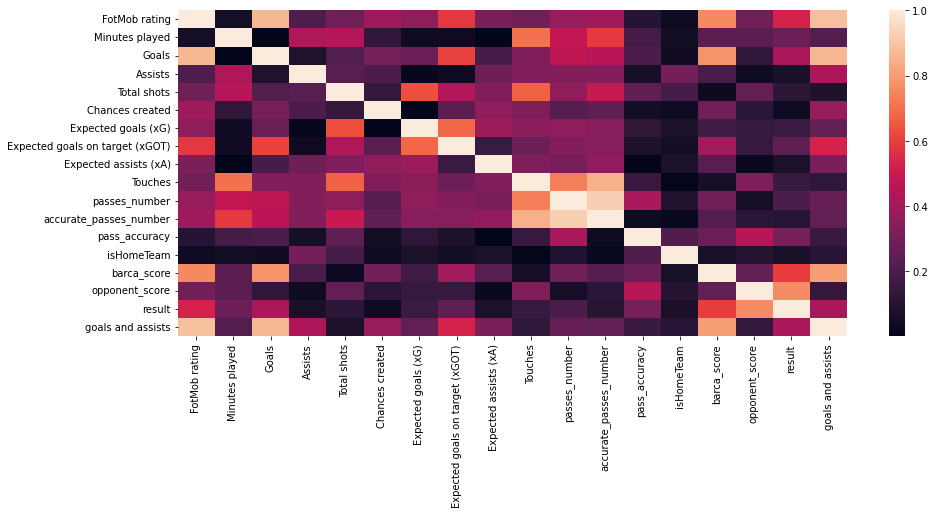

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6),)
sns.heatmap(correlation_m)

In [ ]:
for column in correlation_m.columns:
    most_correlated = correlation_m[correlation_m[column] > 0.5][column].drop([column]).sort_values(ascending=False).index
    if len(most_correlated) > 0:
        print(column, " : ", ", ".join(most_correlated))

FotMob rating  :  goals and assists, Goals, barca_score, Expected goals on target (xGOT), result
Minutes played  :  Touches, accurate_passes_number
Goals  :  goals and assists, FotMob rating, barca_score, Expected goals on target (xGOT)
Total shots  :  Touches, Expected goals (xG)
Expected goals (xG)  :  Expected goals on target (xGOT), Total shots
Expected goals on target (xGOT)  :  Expected goals (xG), Goals, FotMob rating, goals and assists
Touches  :  accurate_passes_number, passes_number, Minutes played, Total shots
passes_number  :  accurate_passes_number, Touches
accurate_passes_number  :  passes_number, Touches, Minutes played
barca_score  :  goals and assists, Goals, FotMob rating, result
opponent_score  :  result
result  :  opponent_score, barca_score, FotMob rating
goals and assists  :  FotMob rating, Goals, barca_score, Expected goals on target (xGOT)


# Rating
- Lewandowski had an **average FotMob rating of 7.75** in the season, with a **minimum of 5.23** and a **maximum of 9.71**.
-The ratings were generally **high** when the team **won** a game, with a mean of **8.11**, and **low** when the team **lost**, with a mean of **6.45**.
-The player's **lowest rating** of the season was **5.23**, which occurred in a game against Osasuna that the team still won. After looking in the dataset, it was found that Lewandowski only played 31 minutes in that game, which may explain his low rating.
-Lewandowski performed **similarly** in terms of **rating** in both **home** and **away** games.
-There is a **strong correlation** between Lewandowski's **rating** and his **goalscoring** performance. His rating tends to be high when he scores and low when he doesn't. This indicates that goalscoring is a key factor in determining a player's overall performance and rating.
- Out of the 29 games in the season, 16 of them had ratings in the medium range (7.0 <= R < 9.0), while 4 of the games had high ratings (R >= 9.0). On the other hand, 9 of the games had low ratings (R < 7.0). This shows that while Lewandowski generally performed well throughout the season, there were still a few games where his performance was below average.

In [ ]:
info_and_stats["Scored"] = info_and_stats["Goals"].map(lambda x: 1 if x >0 else 0)

In [ ]:
info_and_stats["FotMob rating"].mean()

7.759655172413792

In [ ]:
info_and_stats.groupby("result")["FotMob rating"].describe()

,count,mean,std,min,25%,50%,75%,max
result,,,,,,,,
Draw,5.0,7.4000,1.055817,6.45,6.7800,7.06,7.5700,9.14
Lose,4.0,6.4550,0.494537,5.84,6.1625,6.55,6.8425,6.88
Win,20.0,8.1105,1.043594,5.23,7.6600,8.24,8.8900,9.71


In [ ]:
info_and_stats.groupby("isHomeTeam")["FotMob rating"].describe()

,count,mean,std,min,25%,50%,75%,max
isHomeTeam,,,,,,,,
False,14.0,7.715714,1.162456,5.23,7.0525,8.015,8.5225,9.08
True,15.0,7.800667,1.139652,6.27,6.8450,7.690,8.8700,9.71


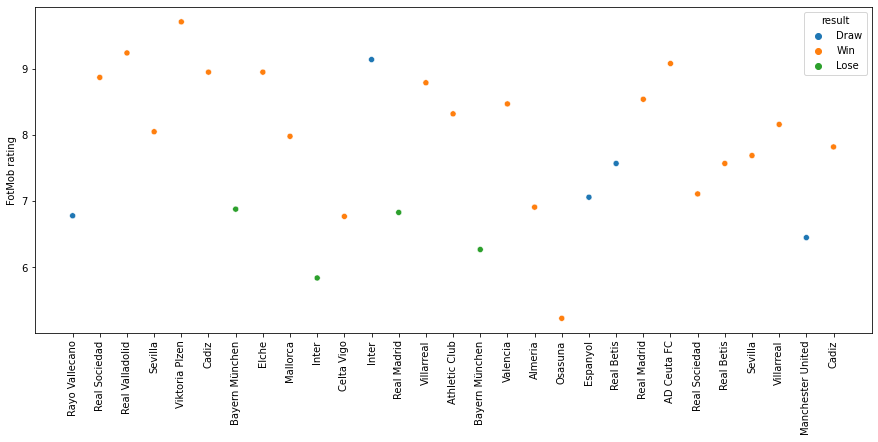

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6),)
lab_x = lewa_team_info['opponent_team'].reset_index().index
sns.scatterplot(x=lab_x, y=info_and_stats["FotMob rating"], hue=info_and_stats["result"]);
ticks = plt.xticks(lab_x, lewa_team_info['opponent_team'], rotation='vertical')

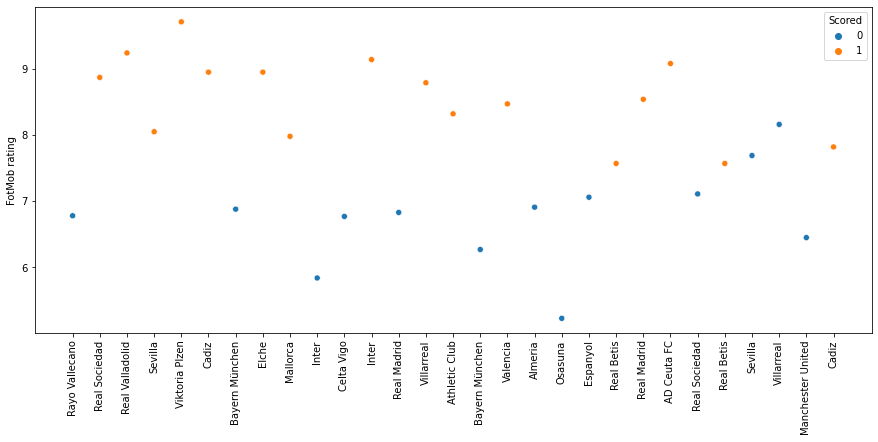

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6),)
lab_x = lewa_team_info['opponent_team'].reset_index().index
sns.scatterplot(x=lab_x, y=info_and_stats["FotMob rating"], hue=info_and_stats["Scored"]);
ticks = plt.xticks(lab_x, lewa_team_info['opponent_team'], rotation='vertical')

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='FotMob rating', ylabel='Density'>

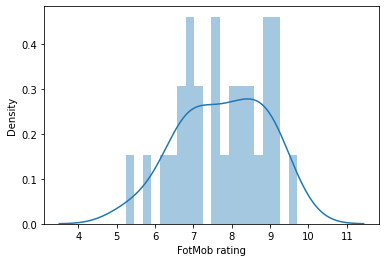

In [ ]:
# distribution of fotmob rating
sns.distplot(info_and_stats["FotMob rating"], bins=20)

In [ ]:
info_and_stats.query('opponent_team == "Osasuna"')

,index,FotMob rating,Minutes played,Goals,Assists,Total shots,Chances created,Expected goals (xG),Expected goals on target (xGOT),Expected assists (xA),Touches,passes_number,accurate_passes_number,pass_accuracy,index,isHomeTeam,opponent_team,barca_score,opponent_score,result,goals and assists,Scored
18,19,5.23,31.0,0.0,0.0,1.0,0.0,0.08,0.18,0.02,17.0,8,10,0.8,1178,False,Osasuna,2.0,1,Win,0.0,0


<AxesSubplot:>

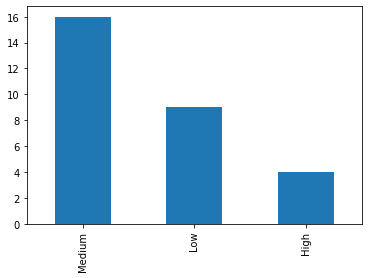

In [ ]:
info_and_stats["FotMob rating"].map(lambda x:"High" if x >= 9.0 else ("Medium" if 7.0<=x<9.0 else "Low")).value_counts().plot(kind="bar")

# top 5 rated games

In [ ]:
info_and_stats.sort_values(by="FotMob rating", ascending=False).iloc[:5]

,index,FotMob rating,Minutes played,Goals,Assists,Total shots,Chances created,Expected goals (xG),Expected goals on target (xGOT),Expected assists (xA),Touches,passes_number,accurate_passes_number,pass_accuracy,index,isHomeTeam,opponent_team,barca_score,opponent_score,result,goals and assists,Scored
4,5,9.71,90.0,3.0,0.0,6.0,2.0,1.100000,1.900,0.8600,51.0,24,35,0.69,512,True,Viktoria Plzen,5.0,1,Win,3.0,1
2,3,9.24,90.0,2.0,0.0,5.0,3.0,0.880000,2.030,0.1800,48.0,27,31,0.87,422,True,Real Valladolid,4.0,0,Win,2.0,1
11,12,9.14,90.0,2.0,0.0,8.0,2.0,0.650000,0.830,0.1800,52.0,13,24,0.54,818,True,Inter,3.0,3,Draw,2.0,1
22,23,9.08,90.0,2.0,0.0,2.0,2.0,0.193333,0.095,0.1868,39.0,20,23,0.87,1444,False,AD Ceuta FC,5.0,0,Win,2.0,1
5,6,8.95,33.0,1.0,2.0,1.0,2.0,0.920000,0.970,0.5600,24.0,10,13,0.77,558,False,Cadiz,4.0,0,Win,3.0,1


# Goals
- Lewandowski had an impressive average scoring rate of 0.82 goals per game.
-He failed to score in 13 matches, scored 1 goal in 9 matches, 2 goals in 6 matches, and scored a hat-trick in one game against Pelzen.
-Lewandowski's percentage of goals scored out of the total Barcelona goals when he played was 0.38%.
-Lewandowski contributed to 14 out of 29 wins when he scored, and Barcelona lost all games in which he did not score.
-Lewandowski scored 11 goals in away games and 13 in home games.
-There was no significant correlation between expected goals and scored goals.
-There was a stronger correlation between expected goals on target and scored goals.
-In some matches, the xGOT was almost equal to the number of goals Lewandowski scored.
- On average, Lewandowski needed 5 shots to score 1 goal, with a goals per shots ratio of 0.21.
- This indicates that Lewandowski was a prolific goalscorer, exceeding his expected goals for the season.

In [ ]:
info_and_stats["Goals"].describe()

count    29.000000
mean      0.827586
std       0.889180
min       0.000000
25%       0.000000
50%       1.000000
75%       1.000000
max       3.000000
Name: Goals, dtype: float64

<AxesSubplot:>

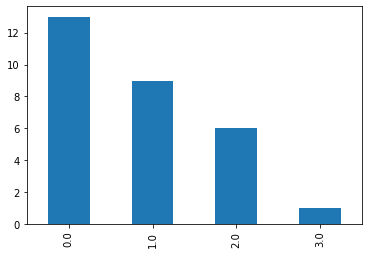

In [ ]:
info_and_stats["Goals"].value_counts().plot(kind="bar")

In [ ]:
# percentage of goals scored / total barcelona goals when he played
info_and_stats["Goals"].sum() / info_and_stats["barca_score"].astype(int).sum()

0.38095238095238093

In [ ]:
# game won when he scores
info_and_stats.query('result == "Win" & (Goals > 0)').shape[0]

14

In [ ]:
info_and_stats.groupby("result").Goals.describe()

,count,mean,std,min,25%,50%,75%,max
result,,,,,,,,
Draw,5.0,0.60,0.894427,0.0,0.0,0.0,1.0,2.0
Lose,4.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0
Win,20.0,1.05,0.887041,0.0,0.0,1.0,2.0,3.0


In [ ]:
info_and_stats.groupby("isHomeTeam").Goals.sum()

isHomeTeam
False    11.0
True     13.0
Name: Goals, dtype: float64

Text(0.5, 1.0, 'Goals vs Expected goals on target')

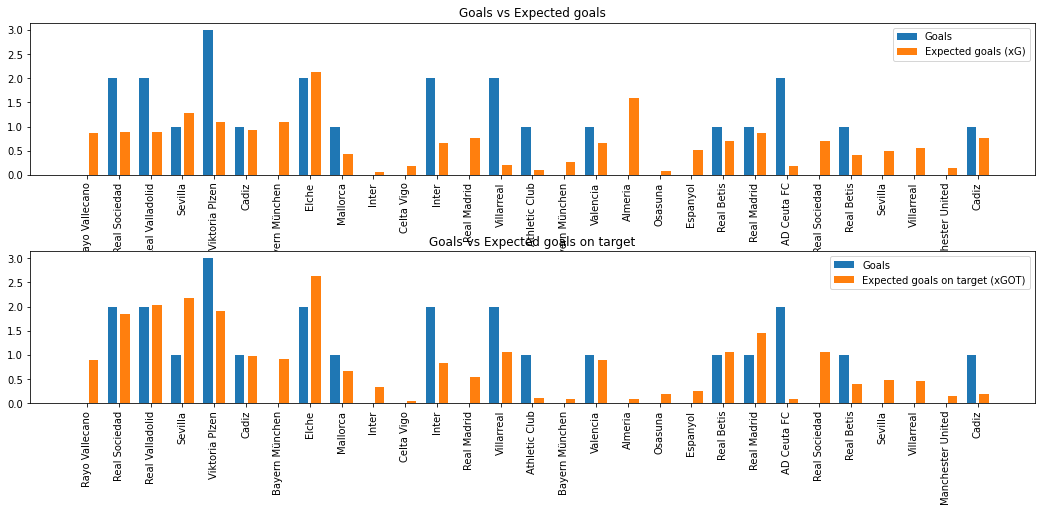

In [ ]:
# goals vs expected goals
fig, ax = plt.subplots(figsize=(18, 7),)
fig.subplots_adjust(hspace = 0.5)
lab_x = info_and_stats['opponent_team'].reset_index().index

axx = plt.subplot(2,1,1)
axx.bar(lab_x-0.2, info_and_stats['Goals'], width=0.3, label='Goals')
axx.bar(lab_x+0.2, info_and_stats['Expected goals (xG)'], width=0.3, label='Expected goals (xG)')
axx.legend()
axx.legend()
plt.xticks(lab_x, lewa_team_info['opponent_team'],rotation='vertical')
plt.title("Goals vs Expected goals")

axx = plt.subplot(2,1,2)
axx.bar(lab_x-0.2, info_and_stats['Goals'], width=0.3, label='Goals')
axx.bar(lab_x+0.2, info_and_stats['Expected goals on target (xGOT)'], width=0.3, label='Expected goals on target (xGOT)')
axx.legend()
plt.xticks(lab_x, lewa_team_info['opponent_team'],rotation='vertical')
plt.title("Goals vs Expected goals on target")

In [ ]:
(info_and_stats['Expected goals on target (xGOT)'] - info_and_stats['Goals']).abs().mean()

0.5477931034482759

In [ ]:
# goals per shots
total_stats["Goals"]/total_stats["Total shots"]

0.21428571428571427

# Assists
- Lewa had 6 assists, with 1 at home and 5 away.
-Lewa's average assists per game is 0.2.
-The expected assists (xA) metric does not provide an accurate representation of the number of assists made by Lewa.

In [ ]:
info_and_stats["Assists"].describe()


count    29.000000
mean      0.206897
std       0.491304
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       2.000000
Name: Assists, dtype: float64

In [ ]:
info_and_stats["Assists"].sum()

6.0

<AxesSubplot:xlabel='isHomeTeam'>

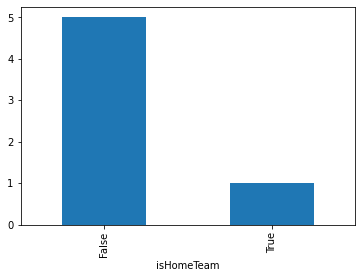

In [ ]:
info_and_stats.groupby("isHomeTeam")["Assists"].sum().plot(kind="bar")

Text(0.5, 1.0, 'Assists vs Expected assists')

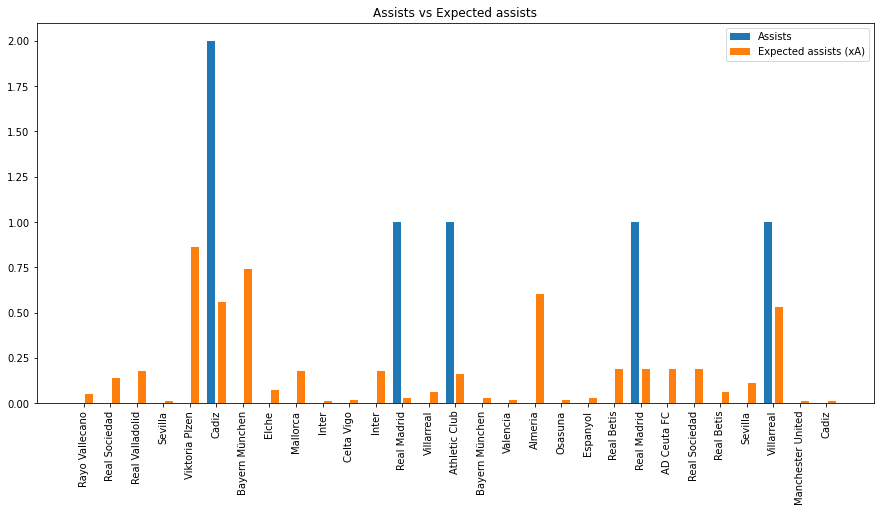

In [ ]:
# assists vs expected assists
fig, ax = plt.subplots(figsize=(15, 7),)
fig.subplots_adjust(hspace = 0.5)
lab_x = info_and_stats['opponent_team'].reset_index().index
ax.bar(lab_x-0.2, info_and_stats['Assists'], width=0.3, label='Assists')
ax.bar(lab_x+0.2, info_and_stats['Expected assists (xA)'], width=0.3, label='Expected assists (xA)')
ax.legend()
plt.xticks(lab_x, lewa_team_info['opponent_team'],rotation='vertical')
plt.title("Assists vs Expected assists")

# Goals + assists

- Lewa has an average of 1 goal or assist per match.
-Lewa's scoring or assisting has contributed to 15 out of 20 wins.
-Lewa contributed to 47% of Barcelona's goals.

In [ ]:
info_and_stats["goals and assists"].describe()

count    29.000000
mean      1.034483
std       0.981353
min       0.000000
25%       0.000000
50%       1.000000
75%       2.000000
max       3.000000
Name: goals and assists, dtype: float64

In [ ]:
# win contribution by scoring or assisting
info_and_stats.query('result == "Win" & (`goals and assists` > 0)').shape[0]

15

In [ ]:
info_and_stats.query('result == "Win"').shape[0]

20

In [ ]:
# score contribution
info_and_stats["goals and assists"].sum()/info_and_stats["barca_score"].sum()

0.47619047619047616

# shots
- Lewa made at least one shot in every match.
-There is a correlation between the expected goals (xG) and total shots.
-On average, he made 3.86 shots per match.
-Most of the total shots are in the range of 1 to 6.

In [ ]:
info_and_stats['Total shots'].describe()

count    29.000000
mean      3.862069
std       1.922129
min       1.000000
25%       2.000000
50%       4.000000
75%       5.000000
max       8.000000
Name: Total shots, dtype: float64

Text(0.5, 1.0, 'Total shots vs Expected goals')

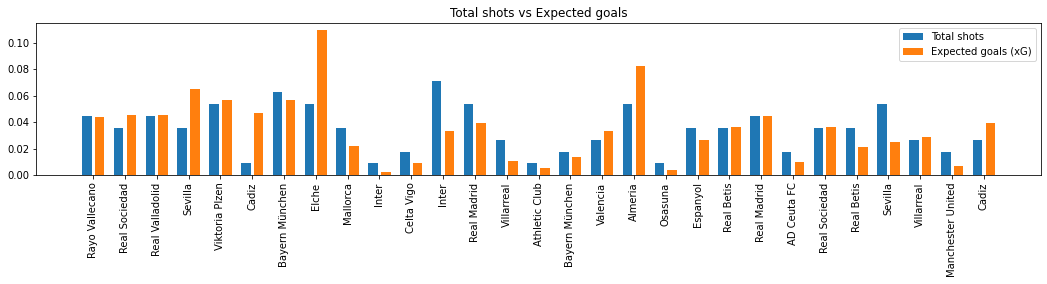

In [ ]:
fig, ax = plt.subplots(figsize=(18, 7),)
fig.subplots_adjust(hspace = 0.5)
lab_x = info_and_stats['opponent_team'].reset_index().index

axx = plt.subplot(2,1,1)
axx.bar(lab_x-0.2, info_and_stats['Total shots']/info_and_stats['Total shots'].sum(), width=0.3, label='Total shots')
axx.bar(lab_x+0.2, info_and_stats['Expected goals (xG)']/info_and_stats['Expected goals (xG)'].sum(), width=0.3, label='Expected goals (xG)')
axx.legend()
axx.legend()
plt.xticks(lab_x, lewa_team_info['opponent_team'],rotation='vertical')
plt.title("Total shots vs Expected goals")

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Total shots', ylabel='Density'>

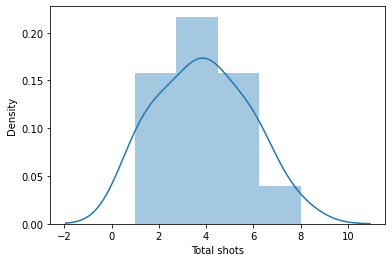

In [ ]:
sns.distplot(info_and_stats['Total shots'])

# Passes
- Lewa's average pass accuracy is 75%.
-Pass accuracy tends to be higher when the team wins compared to when they draw or lose.

In [ ]:
info_and_stats["pass_accuracy"].describe()

count    29.000000
mean      0.753793
std       0.095335
min       0.540000
25%       0.690000
50%       0.770000
75%       0.820000
max       0.920000
Name: pass_accuracy, dtype: float64

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='pass_accuracy', ylabel='Density'>

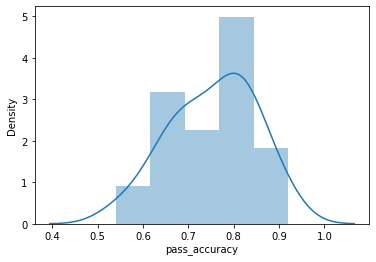

In [ ]:
sns.distplot(info_and_stats["pass_accuracy"])

<AxesSubplot:xlabel='isHomeTeam'>

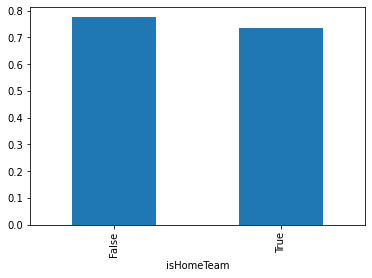

In [ ]:
info_and_stats.groupby("isHomeTeam")["pass_accuracy"].mean().plot(kind='bar')

<AxesSubplot:xlabel='result'>

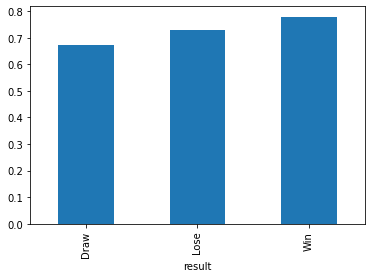

In [ ]:
info_and_stats.groupby("result")["pass_accuracy"].mean().plot(kind='bar')

<AxesSubplot:xlabel='Assists'>

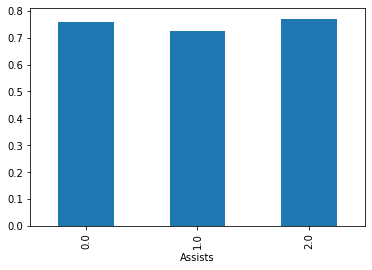

In [ ]:
info_and_stats.groupby("Assists")["pass_accuracy"].mean().plot(kind='bar')

# Conclusion
After analyzing the performance of Barcelona's attacker Lewandowski, it is clear that he is a key player for the team's success. He has a significant impact on the team's win rate, as he contributed to 47% of the team's goals and helped the team win 15 out of 29 games by either scoring or assisting, Lewandowski's performance is vital for the team, and improving his consistency could lead to even greater success for Barcelona.